In [1]:
#https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444

In [7]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from __future__ import division

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [59]:
#load our data from CSV
tx_data = pd.read_csv('C:\\datasets\\onlineretail\\OnlineRetail.csv', encoding='latin1')



In [60]:
tx_data.shape

(541909, 8)

In [61]:
#convert the string date field to datetime
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

#we will be using only UK data
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [62]:
tx_uk.shape

(495478, 8)

In [63]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### create recency cluster

In [64]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']

In [65]:
tx_user.head()
tx_user.describe()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


,CustomerID
count,4372.000000
mean,15299.677722
std,1722.390705
min,12346.000000
25%,13812.750000
50%,15300.500000
75%,16778.250000
max,18287.000000


In [66]:
#get the max purchase date for each customer and create a dataframe with it
tx_max_Purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_Purchase.columns = ['CustomerID', 'MaxPurchaseDate']
tx_max_Purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [67]:
#we take our observation point as the max invoice date in our dataset
tx_max_Purchase['Recency'] = (tx_max_Purchase['MaxPurchaseDate'].max()-tx_max_Purchase['MaxPurchaseDate']).dt.days
tx_max_Purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [68]:
#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_Purchase[['CustomerID', 'Recency']], on = 'CustomerID')
tx_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [69]:
tx_user.describe()

,CustomerID,Recency
count,3950.000000,3950.000000
mean,15562.029367,90.778481
std,1576.848325,100.230349
min,12346.000000,0.000000
25%,14208.250000,16.000000
50%,15571.500000,49.000000
75%,16913.750000,142.000000
max,18287.000000,373.000000


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Number of cluster')

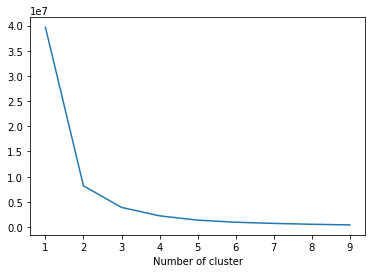

In [70]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [71]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [72]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,3
2,13748.0,95,0
3,15100.0,329,1
4,15291.0,25,3


In [73]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [74]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [75]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


### create frequency cluster

In [76]:
#get order counts for each user and create a dataframe with it
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

In [77]:
#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()
tx_user.describe()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


,CustomerID,Recency,RecencyCluster,Frequency
count,3950.000000,3950.000000,3950.000000,3950.000000
mean,15562.029367,90.778481,2.107848,91.614684
std,1576.848325,100.230349,1.053645,220.557389
min,12346.000000,0.000000,0.000000,1.000000
25%,14208.250000,16.000000,1.000000,17.000000
50%,15571.500000,49.000000,2.000000,41.000000
75%,16913.750000,142.000000,3.000000,101.000000
max,18287.000000,373.000000,3.000000,7983.000000


In [78]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


### CLuster based  on revenue

In [79]:
#calculate revenue for each customer
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [80]:
#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,14688.0,7,3,359,1,5107.38
4,16029.0,38,3,274,1,50992.61


In [81]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])


#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


In [84]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.head()
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()
tx_user.head(10)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5


,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5
5,12921.0,3,3,741,1,16389.74,1,5
6,13468.0,1,3,306,1,5656.75,1,5
7,17690.0,29,3,258,1,4748.45,1,5
8,17017.0,2,3,268,1,8574.11,1,5
9,15601.0,10,3,414,1,6745.36,1,5


0 to 2: Low Value
3 to 4: Mid Value
5+: High Value

In [85]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [86]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


High Value: Improve Retention
Mid Value: Improve Retention + Increase Frequency
Low Value: Increase Frequency